# このノートブックの概要

- Santa 2022
- ベースラインの改良。

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/santa-2022/sample_submission.csv
/kaggle/input/santa-2022/image.png
/kaggle/input/santa-2022/image.csv
/kaggle/input/santa22-manual-update/__results__.html
/kaggle/input/santa22-manual-update/78847.15_submission.csv
/kaggle/input/santa22-manual-update/__resultx__.html
/kaggle/input/santa22-manual-update/__notebook__.ipynb
/kaggle/input/santa22-manual-update/__output__.json
/kaggle/input/santa22-manual-update/custom.css
/kaggle/input/santa22-manual-update/__results___files/__results___3_1.png
/kaggle/input/santa22-manual-update/__results___files/__results___7_0.png
/kaggle/input/more-rotate-and-more-constaint/__results__.html
/kaggle/input/more-rotate-and-more-constaint/submission.csv
/kaggle/input/more-rotate-and-more-constaint/__notebook__.ipynb
/kaggle/input/more-rotate-and-more-constaint/__output__.json
/kaggle/input/more-rotate-and-more-constaint/custom.css
/kaggle/input/more-rotate-and-more-constaint/__results___files/__results___24_1.png


In [2]:
import matplotlib.collections as mc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import io
import pandas as pd
import pickle
import random
import time
from functools import *
from itertools import *
from pathlib import Path
from PIL import Image

In [3]:
plt.style.use('seaborn-whitegrid')
data_dir = Path('/kaggle/input/santa-2022')
DEBUG = False

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(seed=2023)

In [5]:
# Functions to map between cartesian coordinates and array indexes
def cartesian_to_array(x, y, shape):
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j


def array_to_cartesian(i, j, shape):
    m, n = shape[:2]
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    y = (n - 1) // 2 - i
    x = j - (n - 1) // 2
    return x, y


point = (1, 8)
shape = (9, 9, 3)
assert cartesian_to_array(*array_to_cartesian(*point, shape), shape) == point


# Functions to map an image between array and record formats
def image_to_dict(image):
    image = np.atleast_3d(image)
    kv_image = {}
    for i, j in product(range(len(image)), repeat=2):
        kv_image[array_to_cartesian(i, j, image.shape)] = tuple(image[i, j])
    return kv_image


def image_to_df(image):
    return pd.DataFrame(
        [(x, y, r, g, b) for (x, y), (r, g, b) in image_to_dict(image).items()],
        columns=['x', 'y', 'r', 'g', 'b']
    )


def df_to_image(df):
    side = int(len(df) ** 0.5)  # assumes a square image
    return df.set_index(['x', 'y']).to_numpy().reshape(side, side, -1)

In [6]:
def rotate_link(vector, direction):
    x, y = vector
    if direction == 1:  # counter-clockwise
        if y >= x and y > -x:
            x -= 1
        elif y > x and y <= -x:
            y -= 1
        elif y <= x and y < -x:
            x += 1
        else:
            y += 1
    elif direction == -1:  # clockwise
        if y > x and y >= -x:
            x += 1
        elif y >= x and y < -x:
            y += 1
        elif y < x and y <= -x:
            x -= 1
        else:
            y -= 1
    return (x, y)


def rotate(config, i, direction):
    config = config.copy()
    config[i] = rotate_link(config[i], direction)
    return config


def get_direction(u, v):
    """Returns the sign of the angle from u to v."""
    direction = np.sign(np.cross(u, v))
    if direction == 0 and np.dot(u, v) < 0:
        direction = 1
    return direction


def get_position(config):
    return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))


def get_neighbors(config):
    nhbrs = (
        reduce(lambda x, y: rotate(x, *y), enumerate(directions), config)
        for directions in product((-1, 0, 1), repeat=len(config))
    )
    return list(filter(lambda c: c != config, nhbrs))

In [7]:
def get_path_to_point(config, point):
    """Find a path of configurations to `point` starting at `config`."""
    path = [config]
    # Rotate each link, starting with the largest, until the point can
    # be reached by the remaining links. The last link must reach the
    # point itself.
    for i in range(len(config)):
        link = config[i]
        base = get_position(config[:i])
        relbase = (point[0] - base[0], point[1] - base[1])
        position = get_position(config[:i+1])
        relpos = (point[0] - position[0], point[1] - position[1])
        radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
        # Special case when next-to-last link lands on point.
        if radius == 1 and relpos == (0, 0):
            config = rotate(config, i, 1)
            if get_position(config) == point:  # Thanks @pgeiger
                path.append(config)
                break
            else:
                continue
        while np.max(np.abs(relpos)) > radius:
            direction = get_direction(link, relbase)
            config = rotate(config, i, direction)
            path.append(config)
            link = config[i]
            base = get_position(config[:i])
            relbase = (point[0] - base[0], point[1] - base[1])
            position = get_position(config[:i+1])
            relpos = (point[0] - position[0], point[1] - position[1])
            radius = reduce(lambda r, link: r + max(abs(link[0]), abs(link[1])), config[i+1:], 0)
    assert get_position(path[-1]) == point
    return path


def get_path_to_configuration(from_config, to_config):
    path = [from_config]
    config = from_config.copy()
    while config != to_config:
        for i in range(len(config)):
            config = rotate(config, i, get_direction(config[i], to_config[i]))
        path.append(config)
    assert path[-1] == to_config
    return path

In [8]:
# Functions to compute the cost function

# Cost of reconfiguring the robotic arm: the square root of the number of links rotated
def reconfiguration_cost(from_config, to_config):
    nlinks = len(from_config)
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    return np.sqrt(diffs.sum())


# Cost of moving from one color to another: the sum of the absolute change in color components
def color_cost(from_position, to_position, image, color_scale=3.0):
    return np.abs(image[to_position] - image[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
def step_cost(from_config, to_config, image):
    from_position = cartesian_to_array(*get_position(from_config), image.shape)
    to_position = cartesian_to_array(*get_position(to_config), image.shape)
    return (
        reconfiguration_cost(from_config, to_config) +
        color_cost(from_position, to_position, image)
    )


# Compute total cost of path over image
def total_cost(path, image):
    return reduce(
        lambda cost, pair: cost + step_cost(pair[0], pair[1], image),
        zip(path[:-1], path[1:]),
        0,
    )


# total_cost(path, image)

In [9]:
df_image = pd.read_csv(data_dir / 'image.csv')
image = df_to_image(df_image)

## Local search

In [10]:
from tqdm import tqdm

origin = [(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)]

# 初期解となるノートブックを読み込む。
# https://www.kaggle.com/code/ambrosm/santa22-manual-update/data
sol = pd.read_csv('/kaggle/input/santa22-manual-update/78847.15_submission.csv')
sol['config'] = sol['configuration'].apply(lambda x: [tuple(map(int, t.split(' '))) for t in x.split(';')])
sol['position'] = sol['config'].apply(lambda x: get_position(x))
sol['duplicated'] = sol['position'].duplicated(keep='first')

# 合計コストの計算。
print(total_cost(sol['config'], image))

# DF 出力。
print(display(sol))

78847.14535809314


,configuration,config,position,duplicated
0,64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0,"[(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","(0, 0)",False
1,64 1;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0,"[(64, 1), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","(0, 1)",False
2,64 2;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0,"[(64, 2), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","(0, 2)",False
3,64 3;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0,"[(64, 3), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","(0, 3)",False
4,64 4;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0,"[(64, 4), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","(0, 4)",False
...,...,...,...,...
67164,64 4;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0,"[(64, 4), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","(0, 4)",True
67165,64 3;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0,"[(64, 3), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","(0, 3)",True
67166,64 2;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0,"[(64, 2), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","(0, 2)",True
67167,64 1;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0,"[(64, 1), (-32, 0), (-16, 0), (-8, 0), (-4, 0)...","(0, 1)",True


None


In [11]:
# config_path を入力として各ステップのコストを計算し、降順ソートした添字リストをつくる。
def get_config_path_cost_index(config_path):
    config_path_cost = [step_cost(i0, i1, image) for i0, i1 in zip(config_path[:-1], config_path[1:])]
    config_path_cost_index = [i[0] for i in sorted(enumerate(config_path_cost), key=lambda x: x[1])]
    config_path_cost_index.reverse()
    return config_path_cost_index


# Helper function to make check-points during the search
def check_point(config_path_cost_, config_path_):
    with io.open('current_solution_data.pkl', 'wb') as out_file:
        pickle.dump({"cost": config_path_cost_, "solution": config_path_}, out_file)

In [12]:
if False:
    # config_i と config_j が近傍関係にあるとき True を返す関数。
    def check_one_step(config_i, config_j):
         return (np.abs(np.array(config_i) - np.array(config_j) <= 1)).sum() <= 16

    # config_path をもとに近傍グラフを構築する。
    # dic[config] = [config_0, config_1, ..., config_n] のように辞書形式で保持する。
    config_neighbors_dic = {tuple(config): [] for config in config_path}
    for i, config_i in enumerate(config_path):
        for j in range(i+1, len(config_path)):
            config_j = config_path[j]
            # config_i の近傍に config_i を加えない。
            # config_i と config_j の近傍関係を判定する。
            if config_i != config_j and check_one_step(config_i, config_j):
                config_neighbors_dic[tuple(config_i)].append( config_j )
                config_neighbors_dic[tuple(config_j)].append( config_i )

    with open('config_neighbors_dic.pickle', 'wb') as f:
        pickle.dump(config_neighbors_dic, f)

In [13]:
config_path = sol['config'].tolist()

In [14]:
%%time

iteration = 0
max_iteration = 10000
check_pointing_interval = 10

# 暫定解の評価。
config_path_cost = total_cost(config_path, image)

# 11時間50分の間局所探索を継続する。
max_time = 60*60*11 + 60*50
# max_time = 60
start = time.time()
time_exceeded = False

while iteration < max_iteration and time.time() - start < max_time:

    iteration += 1
    improved = False

    # config_path で各ステップのコストを計算し、降順ソートした添字リストをつくる。
    config_path_cost_index = get_config_path_cost_index(config_path)
    
    # ステップコストが大きい辺から順に近傍操作を行う。
    for i0 in config_path_cost_index:
        
        i1 = i0 + 1
        
        # 対応するステップの両端の config を得る。
        config_i0 = config_path[i0]
        config_i1 = config_path[i0+1]
        
        # 対応するステップの両端の近傍を得る。
        config_i0_neighbor = get_neighbors(config_i0)
        config_i1_neighbor = get_neighbors(config_i1)
        
        # 近傍から新たに選ぶ config が経路を構成するための条件を確認する。
        config_i0_neighbor = [config for config in config_i0_neighbor if config != config_i1]
        config_i1_neighbor = [config for config in config_i1_neighbor if config != config_i0]
        
        # 時間超過を確認する。
        if time.time() - start > max_time:
            time_exceeded = True
            break

        # 対応するステップの移動先 config の近傍を順にステップコストを計算する。
        for config_j0 in config_i0_neighbor:
            
            # 時間超過を確認する。
            if time.time() - start > max_time:
                time_exceeded = True
                break

            # config_path 上の config_j0 のインデックスを取得する。
            # 対応するインデックスが複数ある場合はすべてのインデックスを調べる。
            config_j0_index_on_path = [j0 for j0, config in enumerate(config_path)
                                       if config == config_j0 and i0+1 < j0]
            
            # リストが空なら、次の移動先 config の近傍を確認する。
            if config_j0_index_on_path == []:
                continue
            
            # config_path 上の config_j0 に対応するインデックスをすべて調べる。
            for k, j0 in enumerate(config_j0_index_on_path):

                # config_path 上でインデックス j0 の対応するステップを得る。
                j1 = j0 + 1
                config_j1 = config_path[j1]

                # 近傍操作後が経路を構成するか判定する。
                # 選択した config_j1 が config_i1 の近傍内にあるか確認する。
                if config_j1 not in config_i1_neighbor:
                    continue

                # 近傍操作前後のステップコストを計算する。
                c0 = step_cost(config_i0, config_i1, image)
                c1 = step_cost(config_j0, config_j1, image)
                d0 = step_cost(config_i0, config_j0, image)
                d1 = step_cost(config_i1, config_j1, image)

                # diff がマイナスなら改善解を意味する。
                diff = (d0 + d1) - (c0 + c1)

                # 改善解なら暫定解を更新する。
                if diff < 0:
                    improved = True
                    new = config_path[i1:j1]
                    config_path[i1:j1] = new[::-1]
                    config_path_cost += diff

                    print(f'--> Found a better solution at the {iteration}-th iteration;'
                          f' the improvement by transitioning to the better solution was:'
                          f' {diff}')

                    break

            # 改善解が存在するなら config_i0 に対する近傍操作を終える。
            if improved:
                break

        # 改善解が存在するなら config_i0 に対する近傍操作を終える。
        if improved:
            break
        
        if time_exceeded:
            break

    # 探索状況を出力する。
    if iteration % 10 == 0:
        print(f'--> {iteration} neighbors have been explored')

    # チェックポイント処理を行う。
    if iteration % check_pointing_interval == 0:
        print(f'--> Making a check-point of the current best solution with cost: {config_path_cost:.3f}')
        check_point(config_path_cost, config_path)

# 探索終了状況を出力する。
print(f'Search ended after {max_iteration} iterations;'
      f'  the cost of the new best solution found during the search was: {config_path_cost:.3f}')

--> Found a better solution at the 1-th iteration; the improvement by transitioning to the better solution was: -5.359427796626951
--> Found a better solution at the 2-th iteration; the improvement by transitioning to the better solution was: -0.28235294117647136
--> Found a better solution at the 3-th iteration; the improvement by transitioning to the better solution was: -0.35030213360759443
--> Found a better solution at the 4-th iteration; the improvement by transitioning to the better solution was: -0.11500801596053556
--> Found a better solution at the 5-th iteration; the improvement by transitioning to the better solution was: -0.44705882352941106
--> Found a better solution at the 6-th iteration; the improvement by transitioning to the better solution was: -0.31097025229491226
Search ended after 10000 iterations;  the cost of the new best solution found during the search was: 78840.280
CPU times: user 11h 49min 42s, sys: 9.05 s, total: 11h 49min 51s
Wall time: 11h 50min 2s


In [15]:
# 暫定解を再評価する。
print(total_cost(config_path, image))


# Helper function to convert the path generated from the new best solution into the submission format
def config_to_string(config):
    return ';'.join([' '.join(map(str, vector)) for vector in config])


# Make the submission
submission_opt = pd.Series([config_to_string(config) for config in config_path], name="configuration")
submission_opt.to_csv('submission_optimized.csv', index=False)

78840.28023812997


In [16]:
# 生成した経路が通る格子点を集計する。
# 同じ格子点を複数回通過しているなら、無駄が多そう。
pd.DataFrame(config_path).apply(lambda x: get_position(x), axis=1).value_counts()[:20]

(65, -128)     3
(-2, 64)       3
(-114, 77)     3
(18, -61)      3
(102, -128)    3
(101, -128)    3
(100, -128)    3
(98, -128)     3
(97, -128)     3
(79, -128)     3
(78, -128)     3
(99, 52)       3
(-64, 79)      3
(-1, 64)       3
(22, -128)     3
(-14, 75)      3
(21, -128)     3
(20, -128)     3
(39, -128)     3
(38, -128)     3
dtype: int64

In [17]:
def plot_traj(points, image_):
    origin = np.array([0, 0])
    lines = []
    if not (origin == points[0]).all():
        lines.append([origin, points[0]])
    for i_ in range(1, len(points)):
        lines.append([points[i_ - 1], points[i_]])
    if not (origin == points[1]).all():
        lines.append([points[-1], origin])

    colors = []
    for l in lines:
        dist = np.abs(l[0] - l[1]).max()
        if dist <= 2:
            colors.append('b')
        else:
            colors.append('r')

    lc = mc.LineCollection(lines, colors=colors)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)
    ax.add_collection(lc)

    radius = image_.shape[0] // 2
    ax.matshow(image_ * 0.8 + 0.2, extent=(-radius - 0.5, radius + 0.5, -radius - 0.5, radius + 0.5))
    ax.grid(None)

    ax.autoscale()
    fig.show()

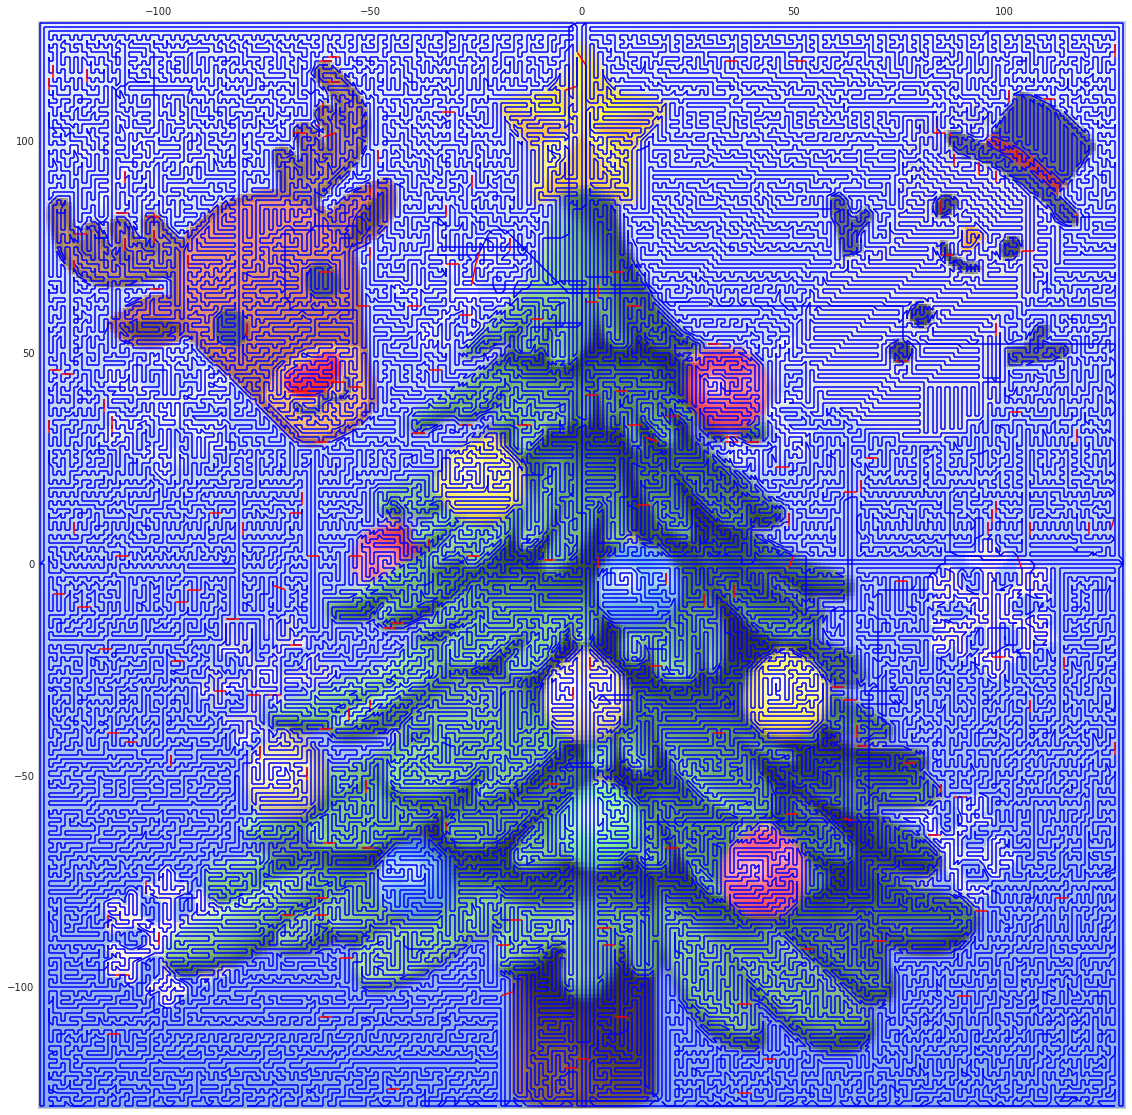

In [18]:
points = [np.array(get_position(config)) for config in config_path]
plot_traj(points, image)